In [2]:
import pandas as pd
import numpy as np
import json
import math
import matplotlib.pyplot as plt

import tensorflow_decision_forests as tfdf

2023-03-03 15:45:58.857876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Function for finding the Pareto points (borrowed from https://github.com/QUVA-Lab/artemis/blob/master/artemis/general/test_pareto_efficiency.py)

def is_pareto(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

In [4]:
report_path = "results_run2.json"

raw_report = json.load(open(report_path))
print(f"Found {len(raw_report)} run(s)")
print(f"First entry:")
for key, value in raw_report[0].items():
  print(f"\t{key}: {value}")

Found 6300 run(s)
First entry:
	algorithm: GRADIENT_BOOSTED_TREES
	num_trees: 5
	shrinkage: 0.1
	subsample: 0.1
	use_hessian_gain: True
	global_growth: False
	max_depth: 4
	max_nodes: -1
	run_idx: 6
	effective_num_trees: 5
	effective_num_nodes: 75
	accuracy: 0.797632
	aucs: [0, 0.932245, 0.932245]
	time_per_predictions_s: 3.575e-08
	repetition_idx: 0


In [5]:
# The fields that are not copied directly from the JSON file.
non_raw_fields = ["aucs", "time_per_predictions_s"]
raw_fields = set(raw_report[0].keys()) - set(non_raw_fields)

dict_repot = {
    key: [row[key] for row in raw_report] for key in raw_fields if key not in non_raw_fields
}

# Extra fields
dict_repot["time_per_predictions_us"] = [x["time_per_predictions_s"] * 1000000 for x in raw_report]
dict_repot["auc"] = [x["aucs"][-1] for x in raw_report]

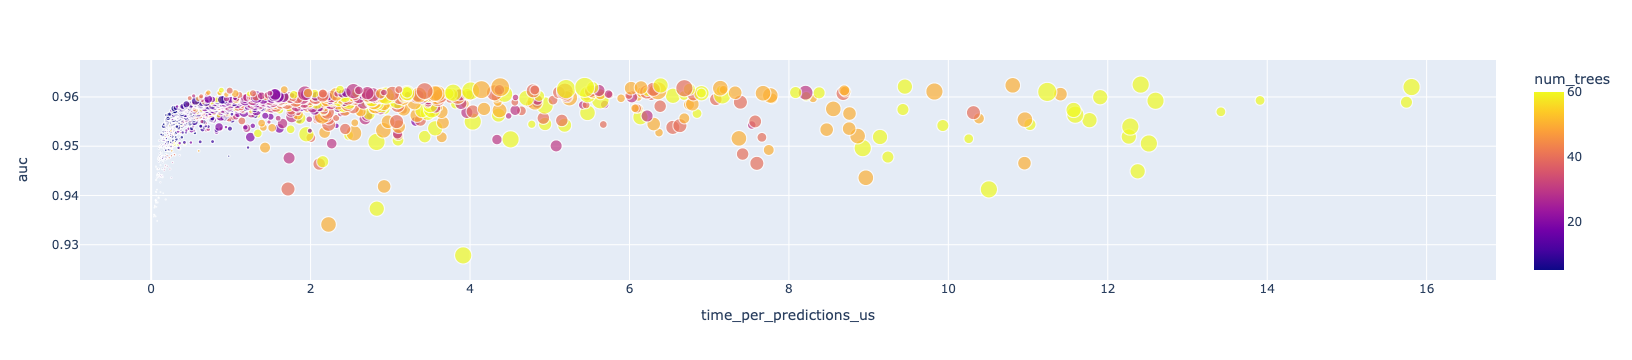

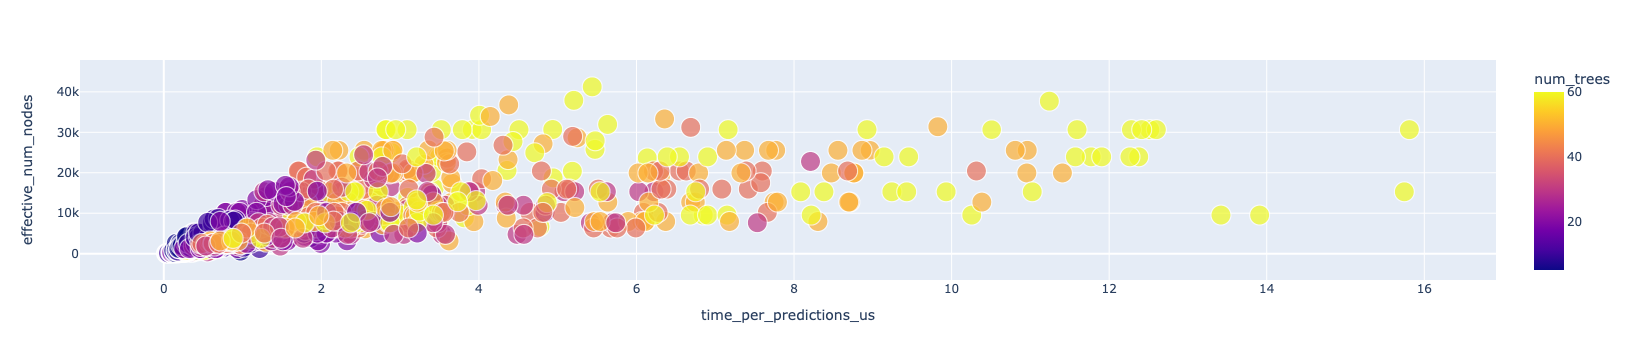

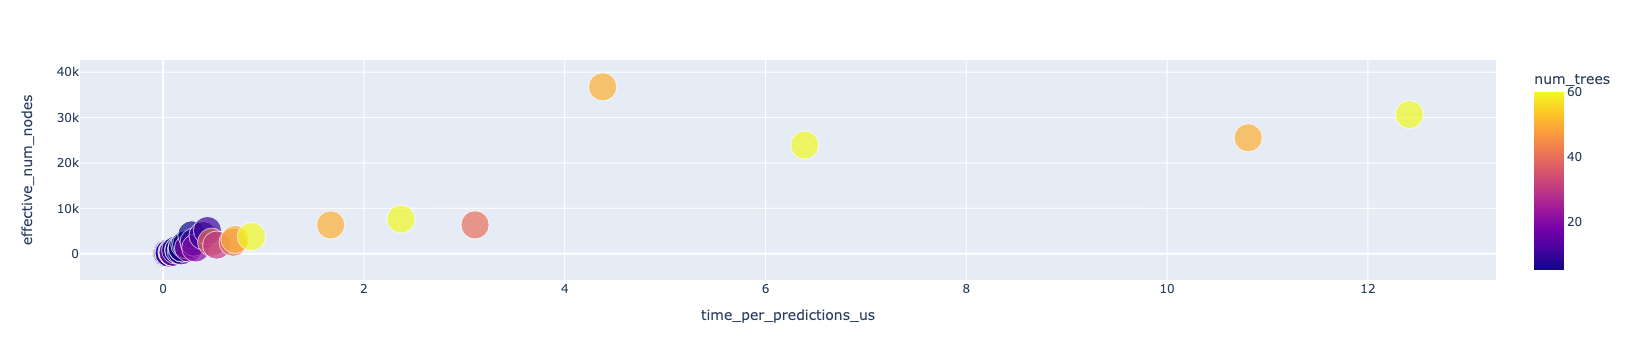

In [7]:
# Let's do some interactive plotting
import plotly.express as px
pd.options.plotting.backend = "plotly"

report = pd.DataFrame(dict_repot)
unique = report.sort_values(by='auc').drop_duplicates(subset = ["run_idx"],keep='last') #Plot just the highest AUC for now
#Plot all the models
fig = px.scatter(unique, x='time_per_predictions_us', y='auc', color="num_trees",size='effective_num_nodes', hover_data=['shrinkage','subsample','global_growth','max_depth','max_nodes','use_hessian_gain'])
fig.show()

fig = px.scatter(unique, x='time_per_predictions_us', y='effective_num_nodes', color="num_trees",size='auc', hover_data=['shrinkage','subsample','global_growth','max_depth','max_nodes','use_hessian_gain'])
fig.show()

#Plot the pareto models only
cost_array_latency =  np.stack((unique["time_per_predictions_us"],
                        1./unique["auc"]),
                        axis=1)
efficient_points = is_pareto(cost_array_latency)
pareto_models_latency = unique[efficient_points]

fig = px.scatter(pareto_models_latency, x='time_per_predictions_us', y='auc', color="num_trees",size='effective_num_nodes', hover_data=['shrinkage','subsample','global_growth','max_depth','max_nodes','use_hessian_gain'])
fig = px.scatter(pareto_models_latency, x='time_per_predictions_us', y='effective_num_nodes', color="num_trees",size='auc', hover_data=['shrinkage','subsample','global_growth','max_depth','max_nodes','use_hessian_gain'])
fig.show()

In [65]:
aggregated_report = report.groupby("run_idx").agg(['mean','std'])
aggregated_report

/var/folders/lx/xk6v8st56q5cw8gw5s3xxv6c0000gn/T/ipykernel_33602/198957235.py:1: FutureWarning:

['algorithm'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.



effective_num_trees      subsample      max_nodes      max_depth       \
                       mean  std      mean  std      mean  std      mean  std   
run_idx                                                                         
0                       5.0  0.0       0.1  0.0      32.0  0.0      -1.0  0.0   
1                       5.0  0.0       0.1  0.0      64.0  0.0      -1.0  0.0   
2                       5.0  0.0       0.1  0.0      80.0  0.0      -1.0  0.0   
3                       5.0  0.0       0.1  0.0     128.0  0.0      -1.0  0.0   
4                       5.0  0.0       0.1  0.0     200.0  0.0      -1.0  0.0   
...                     ...  ...       ...  ...       ...  ...       ...  ...   
1255                   60.0  0.0       0.3  0.0     256.0  0.0      -1.0  0.0   
1256                   60.0  0.0       0.3  0.0      -1.0  0.0       4.0  0.0   
1257                   60.0  0.0       0.3  0.0      -1.0  0.0       6.0  0.0   
1258                   60.0  0.0       0.3  0.0      -1.0  0.0       8.0  0.0   
1259                   60.0  0.0       0.3  0.0      -1.0  0.0      10.0  0.0   

         accuracy            ... use_hessian_gain      num_trees       \
             mean       std  ...             mean  std      mean  std   
run_idx                      ...                                        
0        0.860623  0.001195  ...              1.0  0.0       5.0  0.0   
1        0.863576  0.001229  ...              1.0  0.0       5.0  0.0   
2        0.862398  0.001619  ...              1.0  0.0       5.0  0.0   
3        0.870615  0.001990  ...              1.0  0.0       5.0  0.0   
4        0.877199  0.001069  ...              1.0  0.0       5.0  0.0   
...           ...       ...  ...              ...  ...       ...  ...   
1255     0.928127  0.000508  ...              0.0  0.0      60.0  0.0   
1256     0.930330  0.000492  ...              0.0  0.0      60.0  0.0   
1257     0.933554  0.000072  ...              0.0  0.0      60.0  0.0   
1258     0.933242  0.000239  ...              0.0  0.0      60.0  0.0   
1259     0.931517  0.000334  ...              0.0  0.0      60.0  0.0   

        effective_num_nodes             time_per_predictions_us            \
                       mean         std                    mean       std   
run_idx                                                                     
0                     315.0    0.000000                 0.08675  0.004747   
1                     635.0    0.000000                 0.15095  0.005644   
2                     795.0    0.000000                 0.18120  0.007540   
3                    1275.0    0.000000                 0.27350  0.009812   
4                    1995.0    0.000000                 0.33495  0.004438   
...                     ...         ...                     ...       ...   
1255                30660.0    0.000000                 4.19140  0.173754   
1256                  896.0    3.162278                 0.34610  0.096725   
1257                 3401.2   53.844220                 0.95930  0.118184   
1258                 9932.4  186.822911                 2.63470  0.532122   
1259                24518.8  407.790633                 2.98605  0.058711   

              auc            
             mean       std  
run_idx                      
0        0.944069  0.000366  
1        0.947372  0.000326  
2        0.948774  0.000297  
3        0.951454  0.000323  
4        0.953417  0.000221  
...           ...       ...  
1255     0.954894  0.000100  
1256     0.955660  0.000385  
1257     0.959272  0.000131  
1258     0.959715  0.000093  
1259     0.958115  0.000216  

[1260 rows x 26 columns]

In [66]:
# Make a latency, a resource, and a total cost array of 
# [Npoints,[AUC, latency]] [Npoints,[AUC,Ntrees*Neffnodes]] [Npoints,[AUC,Ntrees*Neffnodes, latency]]


cost_array_latency =  np.stack((aggregated_report["time_per_predictions_us"]["mean"],
                        1./aggregated_report["auc"]["mean"]),
                        axis=1)
cost_array_resources =  np.stack((aggregated_report["effective_num_nodes"]["mean"],
                        1./aggregated_report["auc"]["mean"]),
                        axis=1)
cost_array_total =  np.stack((aggregated_report["time_per_predictions_us"]["mean"],
                              aggregated_report["effective_num_nodes"]["mean"],
                              1./aggregated_report["auc"]["mean"]),
                        axis=1)

In [67]:
efficient_points = is_pareto(cost_array_latency)
pareto_models_latency = aggregated_report[efficient_points]

efficient_points = is_pareto(cost_array_resources)
pareto_models_resources = aggregated_report[efficient_points]

efficient_points = is_pareto(cost_array_total)
pareto_models_total = aggregated_report[efficient_points]

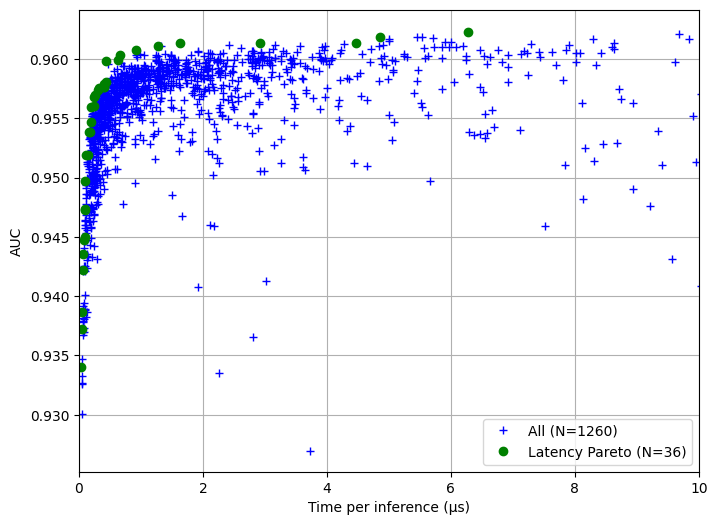

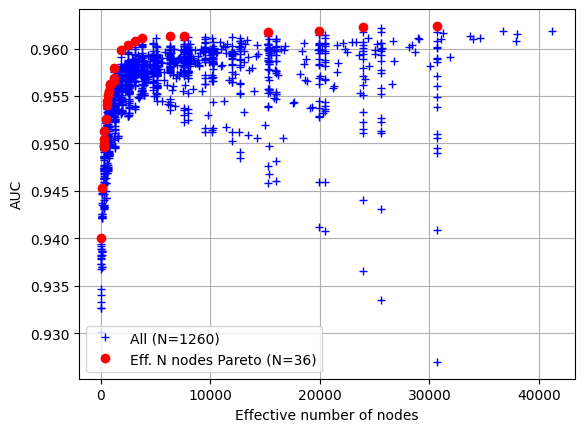

In [68]:

plt.figure(figsize=(8, 6))

plt.subplot(1, 1, 1)

plt.plot(aggregated_report["time_per_predictions_us"]["mean"], aggregated_report["auc"]["mean"], 'b+',label=f"All (N={aggregated_report.shape[0]})")
# plt.plot(pareto_models_total["time_per_predictions_us"]["mean"], pareto_models_total["auc"]["mean"], 'ko', label=f"Total Pareto (N={pareto_models_total.shape[0]})")
# plt.plot(pareto_models_resources["time_per_predictions_us"]["mean"], pareto_models_resources["auc"]["mean"], 'ro', label=f"Eff. N nodes Pareto (N={pareto_models_latency.shape[0]})")
plt.plot(pareto_models_latency["time_per_predictions_us"]["mean"], pareto_models_latency["auc"]["mean"], 'go', label=f"Latency Pareto (N={pareto_models_latency.shape[0]})")
plt.ylabel("AUC")
plt.xlabel("Time per inference (µs)")
plt.xlim((0, 10))
plt.grid()
plt.legend()
plt.show()

plt.subplot(1, 1, 1)

plt.plot(aggregated_report["effective_num_nodes"]["mean"], aggregated_report["auc"]["mean"], 'b+',label=f"All (N={aggregated_report.shape[0]})")
# plt.plot(pareto_models_total["effective_num_nodes"]["mean"], pareto_models_total["auc"]["mean"], 'ko', label=f"Total Pareto (N={pareto_models_total.shape[0]})")
plt.plot(pareto_models_resources["effective_num_nodes"]["mean"], pareto_models_resources["auc"]["mean"], 'ro', label=f"Eff. N nodes Pareto (N={pareto_models_latency.shape[0]})")
# plt.plot(pareto_models_latency["effective_num_nodes"]["mean"], pareto_models_latency["auc"]["mean"], 'go', label=f"Latency Pareto (N={pareto_models_latency.shape[0]})")
plt.ylabel("AUC")
plt.xlabel("Effective number of nodes")
# plt.xlim((0, 10))
plt.grid()
plt.legend()
plt.show()

Text(0.5, 0.5, 'Eff. number of nodes')

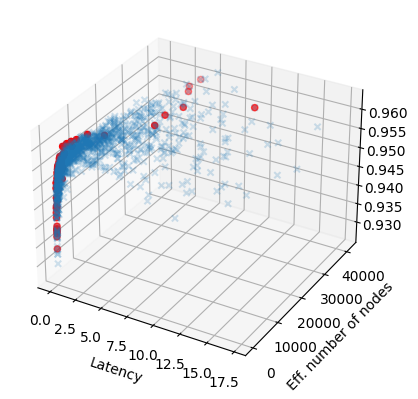

In [69]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(aggregated_report["time_per_predictions_us"]["mean"],
                aggregated_report["effective_num_nodes"]["mean"], 
                aggregated_report["auc"]["mean"],alpha=0.2,marker='x')
ax.scatter(pareto_models_total["time_per_predictions_us"]["mean"],
                pareto_models_total["effective_num_nodes"]["mean"], 
                pareto_models_total["auc"]["mean"],c='red')

plt.xlabel("Latency")
plt.ylabel("Eff. number of nodes")

In [70]:
pareto_models_latency.sort_values(by=('auc','mean'))

effective_num_trees      subsample      max_nodes      max_depth       \
                       mean  std      mean  std      mean  std      mean  std   
run_idx                                                                         
6                       5.0  0.0       0.1  0.0      -1.0  0.0       4.0  0.0   
116                     5.0  0.0       0.3  0.0      -1.0  0.0       4.0  0.0   
206                    10.0  0.0       0.2  0.0      -1.0  0.0       4.0  0.0   
256                    10.0  0.0       0.1  0.0      -1.0  0.0       4.0  0.0   
356                    10.0  0.0       0.3  0.0      -1.0  0.0       4.0  0.0   
306                    10.0  0.0       0.1  0.0      -1.0  0.0       4.0  0.0   
20                      5.0  0.0       0.2  0.0      32.0  0.0      -1.0  0.0   
7                       5.0  0.0       0.1  0.0      -1.0  0.0       6.0  0.0   
47                      5.0  0.0       0.3  0.0      -1.0  0.0       6.0  0.0   
526                    20.0  0.0       0.3  0.0      -1.0  0.0       4.0  0.0   
12                      5.0  0.0       0.1  0.0      80.0  0.0      -1.0  0.0   
52                      5.0  0.0       0.3  0.0      80.0  0.0      -1.0  0.0   
15                      5.0  0.0       0.1  0.0     256.0  0.0      -1.0  0.0   
92                      5.0  0.0       0.2  0.0      80.0  0.0      -1.0  0.0   
98                      5.0  0.0       0.2  0.0      -1.0  0.0       8.0  0.0   
173                     5.0  0.0       0.3  0.0     128.0  0.0      -1.0  0.0   
154                     5.0  0.0       0.2  0.0     200.0  0.0      -1.0  0.0   
115                     5.0  0.0       0.3  0.0     256.0  0.0      -1.0  0.0   
510                    20.0  0.0       0.2  0.0      32.0  0.0      -1.0  0.0   
333                    10.0  0.0       0.2  0.0     128.0  0.0      -1.0  0.0   
530                    20.0  0.0       0.3  0.0      32.0  0.0      -1.0  0.0   
293                    10.0  0.0       0.3  0.0     128.0  0.0      -1.0  0.0   
660                    30.0  0.0       0.1  0.0      32.0  0.0      -1.0  0.0   
358                    10.0  0.0       0.3  0.0      -1.0  0.0       8.0  0.0   
295                    10.0  0.0       0.3  0.0     256.0  0.0      -1.0  0.0   
700                    30.0  0.0       0.3  0.0      32.0  0.0      -1.0  0.0   
820                    40.0  0.0       0.3  0.0      32.0  0.0      -1.0  0.0   
880                    40.0  0.0       0.3  0.0      32.0  0.0      -1.0  0.0   
1000                   50.0  0.0       0.3  0.0      32.0  0.0      -1.0  0.0   
1180                   60.0  0.0       0.3  0.0      32.0  0.0      -1.0  0.0   
1001                   50.0  0.0       0.3  0.0      64.0  0.0      -1.0  0.0   
1181                   60.0  0.0       0.3  0.0      64.0  0.0      -1.0  0.0   
959                    50.0  0.0       0.3  0.0      -1.0  0.0      10.0  0.0   
949                    50.0  0.0       0.3  0.0      -1.0  0.0      10.0  0.0   
1124                   60.0  0.0       0.3  0.0     200.0  0.0      -1.0  0.0   
1125                   60.0  0.0       0.3  0.0     256.0  0.0      -1.0  0.0   

         accuracy            ... use_hessian_gain      num_trees       \
             mean       std  ...             mean  std      mean  std   
run_idx                      ...                                        
6        0.797632  0.000000  ...              1.0  0.0       5.0  0.0   
116      0.911274  0.002399  ...              0.0  0.0       5.0  0.0   
206      0.907830  0.002757  ...              1.0  0.0      10.0  0.0   
256      0.916873  0.000359  ...              0.0  0.0      10.0  0.0   
356      0.917440  0.000901  ...              0.0  0.0      10.0  0.0   
306      0.917847  0.000760  ...              1.0  0.0      10.0  0.0   
20       0.862562  0.001750  ...              1.0  0.0       5.0  0.0   
7        0.868005  0.003065  ...              1.0  0.0       5.0  0.0   
47       0.866577  0.001638  ...             

In [71]:
# Get dataset
from scipy.io import arff

input_ds_path = "dataset/hls4ml_HLF.arff"
output_train_ds_path = "dataset/hls4ml_HLF_train.csv"
output_test_ds_path = "dataset/hls4ml_HLF_test.csv"

# If positive_class is set, the dataset is converted to a binary classification
# dataset where "positive_class" defines the positive class.
# If positive_class is None, the dataset is left as a multi-class classification
# dataset.
positive_class = b"t"
# positive_class = None

# ==========
#    Code
# ==========

print("Load dataset")
data_arff = arff.loadarff(input_ds_path)
data_pd = pd.DataFrame(data_arff[0])
print(data_pd.head())

print("Class distribution: ", data_pd["class"].value_counts())

if positive_class is not None:
  data_pd["class"] = data_pd["class"] != b"t"
  print(
      "Class distribution after conversion: ", data_pd["class"].value_counts()
  )

# Split dataset into a training and testing set.
np.random.seed(12345)
test_indices = np.random.rand(len(data_pd)) < 0.20
test_ds_pd = data_pd[test_indices]
train_ds_pd = data_pd[~test_indices]

print("Save test dataset")
test_ds_pd.to_csv(output_test_ds_path, index=False)

print("Save train dataset")
train_ds_pd.to_csv(output_train_ds_path, index=False)

# Train the model
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label='class')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label='class')

Load dataset
      zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0 -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1 -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2 -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3 -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4 -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   

   d2_b1_mmdt  d2_b2_mmdt  d2_a1_b1_mmdt  d2_a1_b2_mmdt  m2_b1_mmdt  \
0    1.769445    2.123898       1.769445       0.308185    0.135687   
1    2.038834    2.563099       2.038834       0.211886    0.063729   
2    1.269254    1.346238       1.269254       0.246488    0.115636   
3    0.966505    0.601864       0.966505       0.160756    0.082196   
4    0.552002    0.183821       0.552002       0.084338    0.048006   

   m2_b2_mmdt  n2_b1_mmdt  n2_b2_mmdt   mass_mmdt  multiplicity class  
0    0.083278    0.412136    0.299058

2023-03-03 14:39:02.745636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import conifer
import sys,os
from joblib import Parallel, delayed

#Loop over the pareto models and create hls projects for them
def makeHLS(index,row):
    print(row)
    growth = 'LOCAL' if row['global_growth']['mean']==False else 'BEST_FIRST_GLOBAL'
    max_nodes = None if int(row['max_nodes']['mean'])==-1 else int(row['max_nodes']['mean'])
    model = tfdf.keras.GradientBoostedTreesModel(num_trees = int(row['num_trees']['mean']),
                                                 shrinkage = float(row['shrinkage']['mean']),
                                                 subsample = float(row['subsample']['mean']),
                                                 use_hessian_gain = bool(row['use_hessian_gain']['mean']),
                                                 growing_strategy = growth, #What is this? growing_strategy: Optional[str] = 'LOCAL' vs 'GLOBAL'??
                                                 max_depth = int(row['max_depth']['mean']),
                                                 max_num_nodes = max_nodes
                                                )
    model.fit(train_ds,verbose=2)
    model.save(f"latency_optimized_models/model_{index}")
#     model.compile(metrics=["accuracy"])
#     evaluation = model.evaluate(test_ds, return_dict=True)
#     print()
#     from IPython.display import display, HTML
#     display(HTML(tfdf.model_plotter.plot_model(model, tree_idx=0, max_depth=3)))
    
    # Create a conifer config
    cfg = conifer.backends.xilinxhls.auto_config()
    cfg["Precision"] = "ap_fixed<16,6,AP_RND,AP_SAT>"
    cfg["OutputDir"] = f'model_{index}'
    cfg["XilinxPart"] = "xcu250-figd2104-2L-e"
    
    # Create and compile the model
    model_hls = conifer.converters.convert_from_tf_df(model, cfg)
    model_hls.write() #Can also just copy the my_prj.json to yavin, and do conifer.model.load_model(my_prj.json)
    
    return model
    # model_hls.compile() #clone apfixed headers from xilinx, set envvar in conifer to where they are located
    
    # Create a conifer FPU config
    # cfg = conifer.backends.fpu.auto_config()
    # cfg['OutputDir'] = 'prj_fpu'
    # fpu_model = conifer.converters.convert_from_tf_df(model, cfg)
    # fpu_model.write()
    # np.save(f'{cfg["OutputDir"]}/X.npy', X.astype('float32'))
    # np.save(f'{cfg["OutputDir"]}/y.npy', y.astype('float32'))
    
    
    
# Parallel(n_jobs=4, backend='multiprocessing')(delayed(makeHLS)(index, row) for index, row in pareto_models_latency.iterrows())
models_latency = {}
for index, row in pareto_models_latency.iterrows():
    print(row)
    model = makeHLS(index,row)
    models_latency[index] = model

runtime module could not be imported. Interacting with FPUs will not be possible.


effective_num_trees      mean     5.000000
                         std      0.000000
subsample                mean     0.100000
                         std      0.000000
max_nodes                mean    -1.000000
                         std      0.000000
max_depth                mean     4.000000
                         std      0.000000
accuracy                 mean     0.797632
                         std      0.000000
global_growth            mean     0.000000
                         std      0.000000
shrinkage                mean     0.100000
                         std      0.000000
repetition_idx           mean     2.000000
                         std      1.581139
use_hessian_gain         mean     1.000000
                         std      0.000000
num_trees                mean     5.000000
                         std      0.000000
effective_num_nodes      mean    75.000000
                         std      0.000000
time_per_predictions_us  mean     0.033600
           

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Normalized tensor features:
 {'zlogz': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'c1_b0_mmdt': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'c1_b1_mmdt': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_2:0' shape=(None,) dtype=float32>), 'c1_b2_mmdt': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_3:0' shape=(None,) dtype=float32>), 'c2_b1_mmdt': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_4:0' shape=(None,) dtype=float32>), 'c2_b2_mmdt': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_5:0' shape=(None,) dtype=float32>), 'd2_b1_mmdt': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_6:0' shape=(None,) dtype=float32>), 'd2_b2_mmdt': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_7:0' shape=(None,) dtype=floa

[INFO 2023-03-03T14:39:12.306391+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:39:12.311858+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:39:12.312988+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:39:12.313008+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:39:12.43388+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" N

Model trained in 0:00:01.404716
Compiling model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_6/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_6/assets


effective_num_trees      mean      5.000000
                         std       0.000000
subsample                mean      0.100000
                         std       0.000000
max_nodes                mean     -1.000000
                         std       0.000000
max_depth                mean      6.000000
                         std       0.000000
accuracy                 mean      0.868005
                         std       0.003065
global_growth            mean      0.000000
                         std       0.000000
shrinkage                mean      0.100000
                         std       0.000000
repetition_idx           mean      2.000000
                         std       1.581139
use_hessian_gain         mean      1.000000
                         std       0.000000
num_trees                mean      5.000000
                         std       0.000000
effective_num_nodes      mean    313.400000
                         std       0.894427
time_per_predictions_us  mean   

[INFO 2023-03-03T14:39:21.971073+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:39:21.971095+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:39:21.971134+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:39:21.971144+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:39:22.086063+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" 

Model trained in 0:00:02.261671
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_7/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_7/assets


effective_num_trees      mean      5.000000
                         std       0.000000
subsample                mean      0.100000
                         std       0.000000
max_nodes                mean     80.000000
                         std       0.000000
max_depth                mean     -1.000000
                         std       0.000000
accuracy                 mean      0.877864
                         std       0.002703
global_growth            mean      1.000000
                         std       0.000000
shrinkage                mean      0.100000
                         std       0.000000
repetition_idx           mean      2.000000
                         std       1.581139
use_hessian_gain         mean      0.000000
                         std       0.000000
num_trees                mean      5.000000
                         std       0.000000
effective_num_nodes      mean    795.000000
                         std       0.000000
time_per_predictions_us  mean   

[INFO 2023-03-03T14:39:32.023326+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:39:32.023349+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:39:32.023421+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:39:32.023432+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:39:32.139159+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" 

Model trained in 0:00:05.615228
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_12/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_12/assets


effective_num_trees      mean       5.000000
                         std        0.000000
subsample                mean       0.100000
                         std        0.000000
max_nodes                mean     256.000000
                         std        0.000000
max_depth                mean      -1.000000
                         std        0.000000
accuracy                 mean       0.894306
                         std        0.002009
global_growth            mean       1.000000
                         std        0.000000
shrinkage                mean       0.100000
                         std        0.000000
repetition_idx           mean       2.000000
                         std        1.581139
use_hessian_gain         mean       0.000000
                         std        0.000000
num_trees                mean       5.000000
                         std        0.000000
effective_num_nodes      mean    2555.000000
                         std        0.000000
time_per_p

[INFO 2023-03-03T14:39:45.852227+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:39:45.852248+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:39:45.852285+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:39:45.852296+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:39:45.970622+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" 

Model trained in 0:00:06.805251
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_15/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_15/assets


effective_num_trees      mean      5.000000
                         std       0.000000
subsample                mean      0.200000
                         std       0.000000
max_nodes                mean     32.000000
                         std       0.000000
max_depth                mean     -1.000000
                         std       0.000000
accuracy                 mean      0.862562
                         std       0.001750
global_growth            mean      1.000000
                         std       0.000000
shrinkage                mean      0.100000
                         std       0.000000
repetition_idx           mean      2.000000
                         std       1.581139
use_hessian_gain         mean      1.000000
                         std       0.000000
num_trees                mean      5.000000
                         std       0.000000
effective_num_nodes      mean    315.000000
                         std       0.000000
time_per_predictions_us  mean   

Training dataset read in 0:00:07.188270. Found 663506 examples.
Training model...


[INFO 2023-03-03T14:40:04.291176+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:40:04.291198+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:40:04.291236+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:40:04.291247+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:40:04.404683+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" 

Model trained in 0:00:03.629754
Compiling model...


Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_20/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_20/assets


effective_num_trees      mean      5.000000
                         std       0.000000
subsample                mean      0.300000
                         std       0.000000
max_nodes                mean     -1.000000
                         std       0.000000
max_depth                mean      6.000000
                         std       0.000000
accuracy                 mean      0.866577
                         std       0.001638
global_growth            mean      0.000000
                         std       0.000000
shrinkage                mean      0.100000
                         std       0.000000
repetition_idx           mean      2.000000
                         std       1.581139
use_hessian_gain         mean      1.000000
                         std       0.000000
num_trees                mean      5.000000
                         std       0.000000
effective_num_nodes      mean    315.000000
                         std       0.000000
time_per_predictions_us  mean   

Training dataset read in 0:00:07.122206. Found 663506 examples.
Training model...


[INFO 2023-03-03T14:46:03.801573+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:46:03.801787+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:46:03.801844+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:46:03.801857+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:46:03.923772+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" 

Model trained in 0:00:02.394202
Compiling model...


Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_47/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_47/assets


effective_num_trees      mean      5.000000
                         std       0.000000
subsample                mean      0.300000
                         std       0.000000
max_nodes                mean     80.000000
                         std       0.000000
max_depth                mean     -1.000000
                         std       0.000000
accuracy                 mean      0.874215
                         std       0.001831
global_growth            mean      1.000000
                         std       0.000000
shrinkage                mean      0.100000
                         std       0.000000
repetition_idx           mean      2.000000
                         std       1.581139
use_hessian_gain         mean      0.000000
                         std       0.000000
num_trees                mean      5.000000
                         std       0.000000
effective_num_nodes      mean    795.000000
                         std       0.000000
time_per_predictions_us  mean   

[INFO 2023-03-03T14:46:14.48599+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:46:14.486012+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:46:14.486087+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:46:14.4861+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:46:14.604407+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" NUM

Model trained in 0:00:05.799715
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_52/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_52/assets


effective_num_trees      mean      5.000000
                         std       0.000000
subsample                mean      0.200000
                         std       0.000000
max_nodes                mean     80.000000
                         std       0.000000
max_depth                mean     -1.000000
                         std       0.000000
accuracy                 mean      0.926869
                         std       0.000770
global_growth            mean      1.000000
                         std       0.000000
shrinkage                mean      0.200000
                         std       0.000000
repetition_idx           mean      2.000000
                         std       1.581139
use_hessian_gain         mean      0.000000
                         std       0.000000
num_trees                mean      5.000000
                         std       0.000000
effective_num_nodes      mean    795.000000
                         std       0.000000
time_per_predictions_us  mean   

[INFO 2023-03-03T14:46:28.454879+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:46:28.4549+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:46:28.454943+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:46:28.454955+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:46:28.566031+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" NU

Model trained in 0:00:05.802894
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_92/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_92/assets


effective_num_trees      mean       5.000000
                         std        0.000000
subsample                mean       0.200000
                         std        0.000000
max_nodes                mean      -1.000000
                         std        0.000000
max_depth                mean       8.000000
                         std        0.000000
accuracy                 mean       0.925876
                         std        0.000375
global_growth            mean       0.000000
                         std        0.000000
shrinkage                mean       0.200000
                         std        0.000000
repetition_idx           mean       2.000000
                         std        1.581139
use_hessian_gain         mean       0.000000
                         std        0.000000
num_trees                mean       5.000000
                         std        0.000000
effective_num_nodes      mean    1219.800000
                         std       17.297399
time_per_p

[INFO 2023-03-03T14:46:41.776561+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:46:41.776585+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:46:41.776648+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:46:41.776665+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:46:41.899748+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" 

Model trained in 0:00:06.288945
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_98/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_98/assets


effective_num_trees      mean       5.000000
                         std        0.000000
subsample                mean       0.300000
                         std        0.000000
max_nodes                mean     256.000000
                         std        0.000000
max_depth                mean      -1.000000
                         std        0.000000
accuracy                 mean       0.929494
                         std        0.000194
global_growth            mean       1.000000
                         std        0.000000
shrinkage                mean       0.200000
                         std        0.000000
repetition_idx           mean       2.000000
                         std        1.581139
use_hessian_gain         mean       0.000000
                         std        0.000000
num_trees                mean       5.000000
                         std        0.000000
effective_num_nodes      mean    2555.000000
                         std        0.000000
time_per_p

[INFO 2023-03-03T14:46:55.659114+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:46:55.659137+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:46:55.659175+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:46:55.659189+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:46:55.776481+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" 

Model trained in 0:00:07.107997
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_115/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_115/assets


effective_num_trees      mean     5.000000
                         std      0.000000
subsample                mean     0.300000
                         std      0.000000
max_nodes                mean    -1.000000
                         std      0.000000
max_depth                mean     4.000000
                         std      0.000000
accuracy                 mean     0.911274
                         std      0.002399
global_growth            mean     0.000000
                         std      0.000000
shrinkage                mean     0.200000
                         std      0.000000
repetition_idx           mean     2.000000
                         std      1.581139
use_hessian_gain         mean     0.000000
                         std      0.000000
num_trees                mean     5.000000
                         std      0.000000
effective_num_nodes      mean    75.000000
                         std      0.000000
time_per_predictions_us  mean     0.046550
           

[INFO 2023-03-03T14:47:14.029362+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:47:14.029398+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:47:14.029449+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:47:14.029463+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:47:14.16234+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" N

Model trained in 0:00:03.347166
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_116/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_116/assets


effective_num_trees      mean       5.000000
                         std        0.000000
subsample                mean       0.200000
                         std        0.000000
max_nodes                mean     200.000000
                         std        0.000000
max_depth                mean      -1.000000
                         std        0.000000
accuracy                 mean       0.931015
                         std        0.000597
global_growth            mean       1.000000
                         std        0.000000
shrinkage                mean       0.300000
                         std        0.000000
repetition_idx           mean       2.000000
                         std        1.581139
use_hessian_gain         mean       0.000000
                         std        0.000000
num_trees                mean       5.000000
                         std        0.000000
effective_num_nodes      mean    1995.000000
                         std        0.000000
time_per_p

[INFO 2023-03-03T14:47:25.171835+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:47:25.171864+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:47:25.171901+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:47:25.171912+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:47:25.285885+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" 

Model trained in 0:00:07.000784
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_154/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_154/assets


effective_num_trees      mean       5.000000
                         std        0.000000
subsample                mean       0.300000
                         std        0.000000
max_nodes                mean     128.000000
                         std        0.000000
max_depth                mean      -1.000000
                         std        0.000000
accuracy                 mean       0.931486
                         std        0.000317
global_growth            mean       1.000000
                         std        0.000000
shrinkage                mean       0.300000
                         std        0.000000
repetition_idx           mean       2.000000
                         std        1.581139
use_hessian_gain         mean       0.000000
                         std        0.000000
num_trees                mean       5.000000
                         std        0.000000
effective_num_nodes      mean    1275.000000
                         std        0.000000
time_per_p

[INFO 2023-03-03T14:47:48.67023+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:47:48.670262+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:47:48.670307+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:47:48.67032+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:47:48.811954+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" NU

Model trained in 0:00:07.113018
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_173/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_173/assets


effective_num_trees      mean     10.000000
                         std       0.000000
subsample                mean      0.200000
                         std       0.000000
max_nodes                mean     -1.000000
                         std       0.000000
max_depth                mean      4.000000
                         std       0.000000
accuracy                 mean      0.907830
                         std       0.002757
global_growth            mean      0.000000
                         std       0.000000
shrinkage                mean      0.100000
                         std       0.000000
repetition_idx           mean      2.000000
                         std       1.581139
use_hessian_gain         mean      1.000000
                         std       0.000000
num_trees                mean     10.000000
                         std       0.000000
effective_num_nodes      mean    150.000000
                         std       0.000000
time_per_predictions_us  mean   

[INFO 2023-03-03T14:48:05.600445+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:48:05.60047+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:48:05.600513+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:48:05.600526+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:48:05.718725+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" N

Model trained in 0:00:02.445356
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_206/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_206/assets


effective_num_trees      mean     10.000000
                         std       0.000000
subsample                mean      0.100000
                         std       0.000000
max_nodes                mean     -1.000000
                         std       0.000000
max_depth                mean      4.000000
                         std       0.000000
accuracy                 mean      0.916873
                         std       0.000359
global_growth            mean      0.000000
                         std       0.000000
shrinkage                mean      0.200000
                         std       0.000000
repetition_idx           mean      2.000000
                         std       1.581139
use_hessian_gain         mean      0.000000
                         std       0.000000
num_trees                mean     10.000000
                         std       0.000000
effective_num_nodes      mean    150.000000
                         std       0.000000
time_per_predictions_us  mean   

[INFO 2023-03-03T14:48:16.759929+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:48:16.759954+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:48:16.76+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:48:16.760013+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:48:16.893714+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" NUME

Model trained in 0:00:06.189315
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_256/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_256/assets


effective_num_trees      mean      10.000000
                         std        0.000000
subsample                mean       0.300000
                         std        0.000000
max_nodes                mean     128.000000
                         std        0.000000
max_depth                mean      -1.000000
                         std        0.000000
accuracy                 mean       0.933165
                         std        0.000209
global_growth            mean       1.000000
                         std        0.000000
shrinkage                mean       0.200000
                         std        0.000000
repetition_idx           mean       2.000000
                         std        1.581139
use_hessian_gain         mean       0.000000
                         std        0.000000
num_trees                mean      10.000000
                         std        0.000000
effective_num_nodes      mean    2550.000000
                         std        0.000000
time_per_p

[INFO 2023-03-03T14:48:30.788815+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:48:30.788838+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:48:30.788876+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:48:30.788887+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:48:30.9019+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" NU

Model trained in 0:00:12.497547
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_293/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_293/assets


effective_num_trees      mean      10.000000
                         std        0.000000
subsample                mean       0.300000
                         std        0.000000
max_nodes                mean     256.000000
                         std        0.000000
max_depth                mean      -1.000000
                         std        0.000000
accuracy                 mean       0.933431
                         std        0.000108
global_growth            mean       1.000000
                         std        0.000000
shrinkage                mean       0.200000
                         std        0.000000
repetition_idx           mean       2.000000
                         std        1.581139
use_hessian_gain         mean       0.000000
                         std        0.000000
num_trees                mean      10.000000
                         std        0.000000
effective_num_nodes      mean    5110.000000
                         std        0.000000
time_per_p

[INFO 2023-03-03T14:48:57.875962+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:48:57.875984+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:48:57.876021+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:48:57.876038+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:48:57.98945+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" N

Model trained in 0:00:13.999326
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_295/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_295/assets


effective_num_trees      mean     10.000000
                         std       0.000000
subsample                mean      0.100000
                         std       0.000000
max_nodes                mean     -1.000000
                         std       0.000000
max_depth                mean      4.000000
                         std       0.000000
accuracy                 mean      0.917847
                         std       0.000760
global_growth            mean      0.000000
                         std       0.000000
shrinkage                mean      0.300000
                         std       0.000000
repetition_idx           mean      2.000000
                         std       1.581139
use_hessian_gain         mean      1.000000
                         std       0.000000
num_trees                mean     10.000000
                         std       0.000000
effective_num_nodes      mean    150.000000
                         std       0.000000
time_per_predictions_us  mean   

[INFO 2023-03-03T14:51:34.525026+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:51:34.525187+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:51:34.525241+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:51:34.525255+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:51:34.656008+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" 

Model trained in 0:00:02.364029
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_306/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_306/assets


effective_num_trees      mean      10.000000
                         std        0.000000
subsample                mean       0.200000
                         std        0.000000
max_nodes                mean     128.000000
                         std        0.000000
max_depth                mean      -1.000000
                         std        0.000000
accuracy                 mean       0.932742
                         std        0.000100
global_growth            mean       1.000000
                         std        0.000000
shrinkage                mean       0.300000
                         std        0.000000
repetition_idx           mean       2.000000
                         std        1.581139
use_hessian_gain         mean       0.000000
                         std        0.000000
num_trees                mean      10.000000
                         std        0.000000
effective_num_nodes      mean    2550.000000
                         std        0.000000
time_per_p

[INFO 2023-03-03T14:51:45.611773+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:51:45.611806+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:51:45.61186+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:51:45.611874+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:51:45.791258+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" N

Model trained in 0:00:12.824063
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_333/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_333/assets


effective_num_trees      mean     10.000000
                         std       0.000000
subsample                mean      0.300000
                         std       0.000000
max_nodes                mean     -1.000000
                         std       0.000000
max_depth                mean      4.000000
                         std       0.000000
accuracy                 mean      0.917440
                         std       0.000901
global_growth            mean      0.000000
                         std       0.000000
shrinkage                mean      0.300000
                         std       0.000000
repetition_idx           mean      2.000000
                         std       1.581139
use_hessian_gain         mean      0.000000
                         std       0.000000
num_trees                mean     10.000000
                         std       0.000000
effective_num_nodes      mean    150.000000
                         std       0.000000
time_per_predictions_us  mean   

[INFO 2023-03-03T14:52:20.276484+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:52:20.276505+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:52:20.27654+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:52:20.276551+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:52:20.390146+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" N

Model trained in 0:00:05.494222
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_356/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_356/assets


effective_num_trees      mean      10.000000
                         std        0.000000
subsample                mean       0.300000
                         std        0.000000
max_nodes                mean      -1.000000
                         std        0.000000
max_depth                mean       8.000000
                         std        0.000000
accuracy                 mean       0.931961
                         std        0.000308
global_growth            mean       0.000000
                         std        0.000000
shrinkage                mean       0.300000
                         std        0.000000
repetition_idx           mean       2.000000
                         std        1.581139
use_hessian_gain         mean       0.000000
                         std        0.000000
num_trees                mean      10.000000
                         std        0.000000
effective_num_nodes      mean    2381.600000
                         std       22.600885
time_per_p

[INFO 2023-03-03T14:52:32.981505+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:52:32.981529+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:52:32.981574+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:52:32.98159+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:52:33.095322+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" N

Model trained in 0:00:11.923175
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_358/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_358/assets


effective_num_trees      mean      20.000000
                         std        0.000000
subsample                mean       0.200000
                         std        0.000000
max_nodes                mean      32.000000
                         std        0.000000
max_depth                mean      -1.000000
                         std        0.000000
accuracy                 mean       0.932853
                         std        0.000237
global_growth            mean       1.000000
                         std        0.000000
shrinkage                mean       0.300000
                         std        0.000000
repetition_idx           mean       2.000000
                         std        1.581139
use_hessian_gain         mean       0.000000
                         std        0.000000
num_trees                mean      20.000000
                         std        0.000000
effective_num_nodes      mean    1260.000000
                         std        0.000000
time_per_p

[INFO 2023-03-03T14:52:53.175395+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:52:53.175424+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:52:53.175462+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:52:53.175473+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:52:53.290881+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" 

Model trained in 0:00:20.807267
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_510/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_510/assets


effective_num_trees      mean     20.000000
                         std       0.000000
subsample                mean      0.300000
                         std       0.000000
max_nodes                mean     -1.000000
                         std       0.000000
max_depth                mean      4.000000
                         std       0.000000
accuracy                 mean      0.923671
                         std       0.000475
global_growth            mean      0.000000
                         std       0.000000
shrinkage                mean      0.300000
                         std       0.000000
repetition_idx           mean      2.000000
                         std       1.581139
use_hessian_gain         mean      1.000000
                         std       0.000000
num_trees                mean     20.000000
                         std       0.000000
effective_num_nodes      mean    300.000000
                         std       0.000000
time_per_predictions_us  mean   

[INFO 2023-03-03T14:53:28.94861+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:53:28.948632+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:53:28.948669+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:53:28.94868+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:53:29.070443+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" NU

Model trained in 0:00:04.334940
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_526/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_526/assets


effective_num_trees      mean      20.000000
                         std        0.000000
subsample                mean       0.300000
                         std        0.000000
max_nodes                mean      32.000000
                         std        0.000000
max_depth                mean      -1.000000
                         std        0.000000
accuracy                 mean       0.933089
                         std        0.000100
global_growth            mean       1.000000
                         std        0.000000
shrinkage                mean       0.300000
                         std        0.000000
repetition_idx           mean       2.000000
                         std        1.581139
use_hessian_gain         mean       0.000000
                         std        0.000000
num_trees                mean      20.000000
                         std        0.000000
effective_num_nodes      mean    1260.000000
                         std        0.000000
time_per_p

[INFO 2023-03-03T14:53:41.446655+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:53:41.446679+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:53:41.446741+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:53:41.446754+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:53:41.568617+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" 

Model trained in 0:00:22.559470
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_530/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_530/assets


effective_num_trees      mean      30.000000
                         std        0.000000
subsample                mean       0.100000
                         std        0.000000
max_nodes                mean      32.000000
                         std        0.000000
max_depth                mean      -1.000000
                         std        0.000000
accuracy                 mean       0.930354
                         std        0.000537
global_growth            mean       1.000000
                         std        0.000000
shrinkage                mean       0.300000
                         std        0.000000
repetition_idx           mean       2.000000
                         std        1.581139
use_hessian_gain         mean       1.000000
                         std        0.000000
num_trees                mean      30.000000
                         std        0.000000
effective_num_nodes      mean    1890.000000
                         std        0.000000
time_per_p

[INFO 2023-03-03T14:54:18.674544+01:00 kernel.cc:814] Start Yggdrasil model training
[INFO 2023-03-03T14:54:18.674568+01:00 kernel.cc:815] Collect training examples
[INFO 2023-03-03T14:54:18.674606+01:00 kernel.cc:423] Number of batches: 664
[INFO 2023-03-03T14:54:18.674618+01:00 kernel.cc:424] Number of examples: 663506
[INFO 2023-03-03T14:54:18.792218+01:00 kernel.cc:837] Training dataset:
Number of records: 663506
Number of columns: 17

Number of columns by type:
	NUMERICAL: 16 (94.1176%)
	CATEGORICAL: 1 (5.88235%)

Columns:

NUMERICAL: 16 (94.1176%)
	0: "c1_b0_mmdt" NUMERICAL mean:0.433294 min:0.0911035 max:0.493779 sd:0.0554962
	1: "c1_b1_mmdt" NUMERICAL mean:0.0377772 min:7.34286e-05 max:0.165237 sd:0.029168
	2: "c1_b2_mmdt" NUMERICAL mean:0.00800038 min:4.47201e-08 max:0.0704305 sd:0.00940775
	3: "c2_b1_mmdt" NUMERICAL mean:0.0456143 min:2.49982e-06 max:0.219034 sd:0.0386699
	4: "c2_b2_mmdt" NUMERICAL mean:0.00761147 min:1.47252e-10 max:0.107914 sd:0.0121785
	5: "d2_a1_b1_mmdt" 

Model trained in 0:00:23.251427
Compiling model...
Model compiled.


INFO:tensorflow:Assets written to: latency_optimized_models/model_660/assets


INFO:tensorflow:Assets written to: latency_optimized_models/model_660/assets


In [14]:
inspector = tfdf.inspector.make_inspector(os.path.join(f"latency_optimized_models/model_{index}", "assets"))
conifer.converters.tf_df._convert_gbt(inspector)

{'max_depth': 3,
 'n_trees': 5,
 'n_classes': 2,
 'n_features': 16,
 'init_predict': [1.3735525608062744],
 'norm': 1,
 'trees': [[{'feature': [1,
     2,
     2,
     -2,
     -2,
     11,
     -2,
     -2,
     12,
     1,
     -2,
     -2,
     1,
     -2,
     -2],
    'threshold': [0.05402085930109024,
     0.008478994481265545,
     0.0017386986874043941,
     -2.0,
     -2.0,
     90.02021789550781,
     -2.0,
     -2.0,
     91.5,
     0.07723668962717056,
     -2.0,
     -2.0,
     0.0839695930480957,
     -2.0,
     -2.0],
    'children_left': [1, 2, 3, -1, -1, 6, -1, -1, 9, 10, -1, -1, 13, -1, -1],
    'children_right': [8, 5, 4, -1, -1, 7, -1, -1, 12, 11, -1, -1, 14, -1, -1],
    'value': [0,
     0,
     0,
     0.11461901664733887,
     0.07685613632202148,
     0,
     -0.3262333273887634,
     -0.05615818500518799,
     0,
     0,
     -0.2729053795337677,
     -0.4292542636394501,
     0,
     -0.022926591336727142,
     -0.24479453265666962]}],
  [{'feature': [2, 2, 1

In [18]:
print(inspector.extract_tree(tree_idx=0))

(c1_b1_mmdt >= 0.05402085930109024; miss=False, score=273699.03125)
    ├─(pos)─ (multiplicity >= 91.5; miss=False, score=231605.359375)
    │        ├─(pos)─ (c1_b1_mmdt >= 0.0839695930480957; miss=False, score=12602.685546875)
    │        │        ├─(pos)─ RegressionValue(value=-0.24479453265666962,n=0.0) (idx=7)
    │        │        └─(neg)─ RegressionValue(value=-0.022926591336727142,n=0.0) (idx=6)
    │        └─(neg)─ (c1_b1_mmdt >= 0.07723668962717056; miss=False, score=232635.984375)
    │                 ├─(pos)─ RegressionValue(value=-0.4292542636394501,n=0.0) (idx=5)
    │                 └─(neg)─ RegressionValue(value=-0.2729053795337677,n=0.0) (idx=4)
    └─(neg)─ (c1_b2_mmdt >= 0.008478994481265545; miss=False, score=66514.5)
             ├─(pos)─ (mass_mmdt >= 90.02021789550781; miss=False, score=5416.82568359375)
             │        ├─(pos)─ RegressionValue(value=-0.05615818500518799,n=0.0) (idx=3)
             │        └─(neg)─ RegressionValue(value=-0.326233327388